## Node Classification on large Knowledge Graphs


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import seaborn as sns
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

### Explore data

In [2]:
dataset = Planetoid(root='../data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [3]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [4]:
print(data.x.shape)
print(data.y.shape)
print(data.x[0][70:150])
print(data.y[0])

torch.Size([2708, 1433])
torch.Size([2708])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1111, 0.0000, 0.0000, 0.0000])
tensor(3)


In [5]:
print(len(data.test_mask) == data.num_nodes)
print(data.test_mask.shape)
print(data.test_mask)

True
torch.Size([2708])
tensor([False, False, False,  ...,  True,  True,  True])


In [6]:
print(data.edge_index.shape)
print(data.edge_index.t().shape)
print(data.edge_index.t())

torch.Size([2, 10556])
torch.Size([10556, 2])
tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])


### Training

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        # Intialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [8]:
# Intialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=decay
)
ce = nn.CrossEntropyLoss() # loss function

cuda:0


In [9]:
output = model(data.x, data.edge_index)
print(output.size())

torch.Size([2708, 7])


In [10]:
print(data.train_mask.size())
print(data.train_mask)

filters = output[data.train_mask]
print(filters.size())

torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
torch.Size([140, 7])


In [11]:
def train():
    model.train() # train mode
    optimizer.zero_grad()
    
    # use all data as input, because all nodes have node features
    output = model(data.x, data.edge_index)
    
    pred = output.argmax(dim=-1)
    correct = pred[data.train_mask] == data.y[data.train_mask]  
    accuracy = int(correct.sum()) / int(data.train_mask.sum())
    
    loss = ce(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss / 10.0 , accuracy
    
losses = []
accs = []
best_acc, best_loss = 0, 100
EPOCHS = 1000 
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}')
    loss, accuracy = train()
    
    if loss <= best_loss and accuracy >= best_acc:
        best_acc = accuracy
        best_loss = loss
        torch.save(model, '../models/GNNs_cora_1000_ce.pth')
        print('Saved new better model')
    
    losses.append(loss)
    accs.append(accuracy)
    print(f'Accuracy: {accuracy:.4f} - Loss: {loss:.4f}')

Epoch: 1
Saved new better model
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 2
Saved new better model
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 3
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 4
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 5
Saved new better model
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 6
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 7
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 8
Saved new better model
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 9
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 10
Saved new better model
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 11
Accuracy: 0.1357 - Loss: 0.1946
Epoch: 12
Accuracy: 0.1500 - Loss: 0.1946
Epoch: 13
Saved new better model
Accuracy: 0.1429 - Loss: 0.1945
Epoch: 14
Accuracy: 0.1571 - Loss: 0.1945
Epoch: 15
Accuracy: 0.1429 - Loss: 0.1946
Epoch: 16
Accuracy: 0.1929 - Loss: 0.1945
Epoch: 17
Accuracy: 0.1500 - Loss: 0.1945
Epoch: 18
Saved new better model
Accuracy: 0.1786 - Loss: 0.1945
Epoch: 19
Accuracy: 0.1071 - Loss: 0.1945
Epoch: 20
Accuracy: 0.1857 - Loss: 0.1945
Epoch: 2

In [12]:
print(f'Best accuracy: {best_acc} - best loss: {best_loss}')

Best accuracy: 0.9428571428571428 - best loss: 0.13011211156845093


In [13]:
# Define the file name
file_name = '../results/GNNs_cora_1000_ce.csv'

# Writing the data into a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Accuracy', 'Loss'])
    for epoch in range(len(accs)):
        writer.writerow([epoch+1, accs[epoch], losses[epoch].item()])

print(f"Training history has been saved to {file_name}")

Training history has been saved to ../results/GNNs_cora_1000_ce.csv


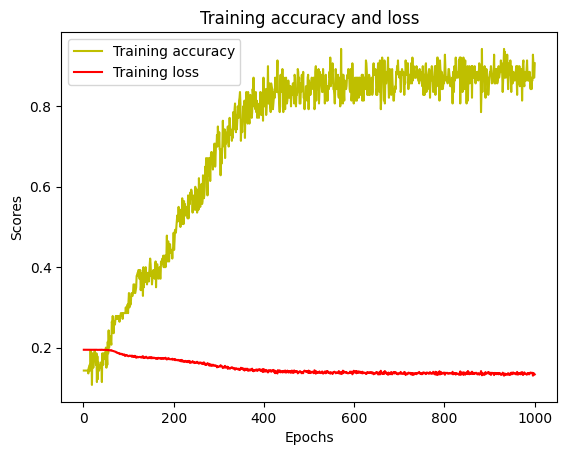

<Figure size 640x480 with 0 Axes>

In [17]:
def read_output(option_csv=False):
    if option_csv==True:
        df = pd.read_csv('../results/GNNs_cora_1000_ce.csv')
        return df['Accuracy'].tolist(), df['Loss'].tolist()
    
    
def visualize(epochs, scores_1, scores_2, legend_1, legend_2, x_label, y_label, title, filename):
    plt.plot(epochs, scores_1, 'y', label=legend_1)
    plt.plot(epochs, scores_2, 'r', label=legend_2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    plt.savefig('../graphs/' + filename)
    

acc_list, loss_list = read_output(option_csv=True)
epochs = range(1, len(acc_list) + 1)
visualize(epochs, acc_list, loss_list, 'Training accuracy', 'Training loss', 'Epochs', 'Scores', 'Training accuracy and loss', 'GNNs_cora_acc_loss_1000_ce.png')

### Run inference

In [18]:
best_model = torch.load('../models/GNNs_cora_1000_ce.pth')

In [19]:
def test(model):
    model.eval() # evaluation mode
    output = model(data.x, data.edge_index)
    
    pred = output.argmax(dim=-1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    accuracy = int(test_correct.sum()) / int(data.test_mask.sum())
    
    loss = ce(output[data.test_mask], data.y[data.test_mask])
    return  loss / 10.0 , accuracy

loss, acc = test(best_model)
print(f'Test accuracy: {acc} - test loss: {loss}')

Test accuracy: 0.7 - test loss: 0.1509750336408615


torch.Size([2708, 7])


<Axes: >

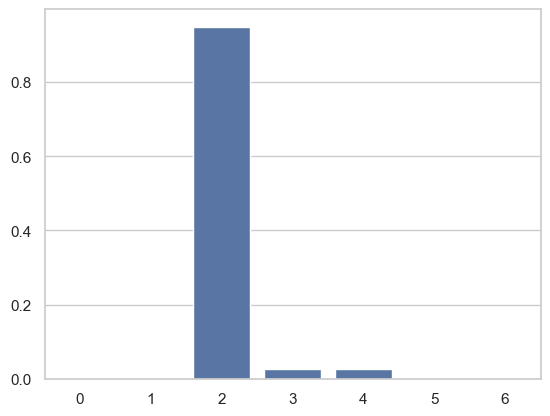

In [21]:
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)

pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [24]:
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(out, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [25]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

In [ ]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

In [ ]:
from IPython.display import Image
with open('embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))